<a href="https://colab.research.google.com/github/RodrigoGuedesDP/Computer_Vision/blob/main/Sesion11A_FineTuning_ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine‑tuning (Debemos usar CUDA!!)
Vamos a entrenar YOLOv8 en un conjunto pequeño de datos usando la API Ultralytics. Hay que ajustar las rutas y parámetros según el dataset.

Como de costumbre: Primero, instalemos ultralytics

In [1]:
!pip -q install ultralytics # Instalamos Ultralytics (nos permitirá usar YOLO)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.0 MB/s eta 0:00:00


## 1. Subamos `datasets.zip` y `bccd.yaml` (archivo de configuración) al Google Colab

## 2. Descomprimimos `dataset.zip`

In [2]:
!unzip datasets.zip

Archive:  datasets.zip
   creating: datasets/
   creating: datasets/BCCD/
   creating: datasets/BCCD/labels/
   creating: datasets/BCCD/labels/train/
  inflating: datasets/BCCD/labels/train/BloodImage_00339.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00287.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00107.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00305.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00089.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00311.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00199.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00193.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00204.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00077.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00083.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00247.txt  
  inflating: datasets/BCCD/labels/train/BloodImage_00212.txt  
  inflating: datasets/BCCD/labe

## 3. Probemos YOLO entrenado con COCO en nuestro dataset BCCD

Descargamos el modelo

In [3]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
import cv2
from pathlib import Path

model_coco = YOLO("yolov8n.pt")          # 80 clases COCO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Usemos el modelo

*   Quizás no te salga ninguna caja. Prueba disminuyendo la confianza
*   Probemos con diferentes imágenes cambiando el valor de idx.
*   Se aconseja bajar la confianza para que se detecten objetos



usando la imagen de prueba: datasets/BCCD/images/val/BloodImage_00004.jpg

image 1/1 /content/datasets/BCCD/images/val/BloodImage_00004.jpg: 480x640 5 persons, 1 cat, 1 cup, 1 apple, 3 donuts, 2 cakes, 1 dining table, 7 vases, 1 toothbrush, 9.2ms
Speed: 1.9ms preprocess, 9.2ms inference, 5.7ms postprocess per image at shape (1, 3, 480, 640)


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

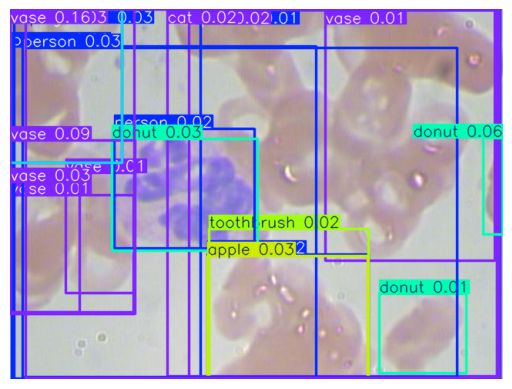

In [6]:
idx = 1
confianza = 0.01

DST     = Path("datasets/BCCD")
test_imgs_list = sorted((DST/"images/val").glob("*.jpg"))
test_img = str(test_imgs_list[idx])
print("usando la imagen de prueba:", test_img)
# pre-entrenado (probablemente no detecta nada)
res0 = model_coco(test_img, conf=confianza)[0]
plt.imshow(cv2.cvtColor(res0.plot(), cv2.COLOR_BGR2RGB)); plt.axis('off')

## 4. Re-entrenemos YOLO para este dataset (Fine-tuning)

### 4.1 Leamos algunos argumentos de la función train
| Argumento | Valor usado | Descripción |
|-----------|-------------|-----------------------------------------|
| `data`    | `"bccd.yaml"` | Apunta al YAML del dataset. Incluye rutas a los splits, número (`nc`) y nombres de clases. |
| `epochs`  | `EPOCHS` (p. ej. `50`) | Pasadas completas por el set de entrenamiento. Más epochs → mejor convergencia; se detiene antes si hay *early-stopping*. |
| `imgsz`   | `640` px | Re-escala la imagen manteniendo aspecto y luego hace *letterbox* hasta 640 × 640 (relleno negro). Ajusta la resolución de entrada: 640 es equilibrio entre detalle y VRAM. |
| `batch`   | `16` | Nº de imágenes por lote. Demasiado grande → “CUDA out of memory”; demasiado pequeño → entrenamiento inestable. |
| `name`    | `FT_RUN` | Etiqueta para el experimento. Crea la carpeta `runs/detect/FT_RUN/`. |
| `patience`| `10` | Nº de epochs sin mejora en mAP antes de activar *early-stopping*. Ahorra tiempo y evita sobreajuste. |
| `optimizer` | `"SGD"` | Algoritmo de actualización de pesos (SGD, AdamW, …). SGD es robusto; AdamW suele converger más rápido en datasets pequeños. |
| `device`  | `0` | GPU a usar (`0`, `1`, …) o `"cpu"`. Con `0` Colab usará la GPU asignada. |
| `freeze`  | `10` | El número de capas que deseas congelar. |


In [7]:
for (name, p) in model_coco.model.named_parameters():
    print(f"{name:<40} {tuple(p.shape)}  requires_grad={p.requires_grad}")

model.0.conv.weight                      (16, 3, 3, 3)  requires_grad=False
model.0.conv.bias                        (16,)  requires_grad=False
model.1.conv.weight                      (32, 16, 3, 3)  requires_grad=False
model.1.conv.bias                        (32,)  requires_grad=False
model.2.cv1.conv.weight                  (32, 32, 1, 1)  requires_grad=False
model.2.cv1.conv.bias                    (32,)  requires_grad=False
model.2.cv2.conv.weight                  (32, 48, 1, 1)  requires_grad=False
model.2.cv2.conv.bias                    (32,)  requires_grad=False
model.2.m.0.cv1.conv.weight              (16, 16, 3, 3)  requires_grad=False
model.2.m.0.cv1.conv.bias                (16,)  requires_grad=False
model.2.m.0.cv2.conv.weight              (16, 16, 3, 3)  requires_grad=False
model.2.m.0.cv2.conv.bias                (16,)  requires_grad=False
model.3.conv.weight                      (64, 32, 3, 3)  requires_grad=False
model.3.conv.bias                        (64,)  requir

In [8]:
FT_RUN = "y8_bccd_ft"
EPOCHS = 50          # 50 × aprox 150 imgs --> 5-7 min en GPU T4

model_ft = YOLO("yolov8n.pt")   # reutilizamos base COCO
model_ft.train(
    data       = "bccd.yaml",
    epochs     = EPOCHS,
    imgsz      = 640,
    batch      = 16,
    name       = FT_RUN,
    patience   = 10,            # early-stopping
    optimizer  = "SGD",
    device     = 0, # "cpu" si ya no quedan creditos
    freeze     = 22,
)

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=bccd.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=22, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=y8_bccd_ft, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=True,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79256030ad20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

# 5. Calculemos el mAP en los datos de validación

In [9]:
metrics = model_ft.val(data="bccd.yaml", imgsz=640, split="val")
print("mAP@0.5 luego de FT:", metrics.box.map50)

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 547.0±188.7 MB/s, size: 19.9 KB)
val: Scanning /content/datasets/BCCD/labels/val.cache... 73 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 73/73 153.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 1.7it/s 3.0s
                   all         73        964      0.772      0.831      0.867      0.548
                   RBC         69        821      0.656      0.839      0.827      0.564
                   WBC         71         72      0.896      0.838      0.944      0.663
             Platelets         40         71      0.763      0.817       0.83      0.416
Speed: 5.5ms preprocess, 6.9ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to /content/runs/detect/val
mAP@0.5 luego d

# 5. Visualicemos resultados

usando la imagen de prueba: datasets/BCCD/images/train/BloodImage_00002.jpg

image 1/1 /content/datasets/BCCD/images/train/BloodImage_00002.jpg: 480x640 3 RBCs, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

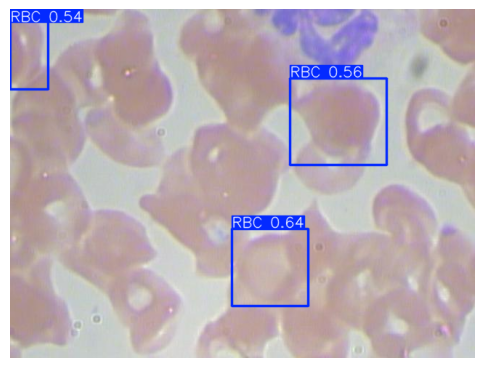

In [12]:
idx = 2
confianza = 0.5

FT_RUN = "y8_bccd_ft"

DST     = Path("datasets/BCCD")
test_imgs_list = sorted((DST/"images/train").glob("*.jpg"))
test_img = str(test_imgs_list[idx])
print("usando la imagen de prueba:", test_img)

best = f"runs/detect/{FT_RUN}/weights/best.pt"
detector = YOLO(best)

res1 = detector(test_img, conf=confianza)[0]
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(res1.plot(), cv2.COLOR_BGR2RGB)); plt.axis('off')